## Import Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import cross_validate
import lightgbm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving us_disaster_declarations.csv to us_disaster_declarations (1).csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['us_disaster_declarations.csv'])) 

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving GDPC1.csv to GDPC1.csv


In [ ]:
import io
gdp = pd.read_csv(io.BytesIO(uploaded['GDPC1.csv']),parse_dates=['DATE'],index_col='DATE')

## Statistical Description

In [ ]:
gdp.head()

,GDPC1
DATE,
1953-04-01,2718.709
1953-07-01,2703.411
1953-10-01,2662.482
1954-01-01,2649.755
1954-04-01,2652.643


In [ ]:
def plot_df(df,x,y,title='',xlabel='Date',ylabel='GDP',dpi=100):
    plt.figure(figsize=(12,4),dpi=dpi)
    plt.plot(x,y,color='tab:red')
    plt.gca().set(title=title,xlabel=xlabel,ylabel=ylabel)
    plt.xticks(rotation=45)
    plt.show()

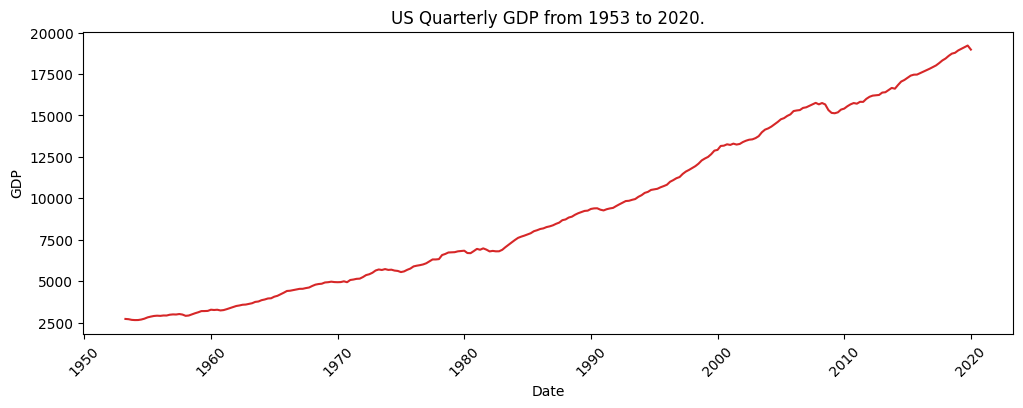

In [ ]:
plot_df(gdp,x=gdp.index,y=gdp.GDPC1,title='US Quarterly GDP from 1953 to 2020.')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181 entries, 0 to 59180
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   fema_declaration_string     59181 non-null  object
 1   disaster_number             59181 non-null  int64 
 2   state                       59181 non-null  object
 3   declaration_type            59181 non-null  object
 4   declaration_date            59181 non-null  object
 5   fy_declared                 59181 non-null  int64 
 6   incident_type               59181 non-null  object
 7   declaration_title           59181 non-null  object
 8   ih_program_declared         59181 non-null  int64 
 9   ia_program_declared         59181 non-null  int64 
 10  pa_program_declared         59181 non-null  int64 
 11  hm_program_declared         59181 non-null  int64 
 12  incident_begin_date         59181 non-null  object
 13  incident_end_date           51026 non-null  ob

In [ ]:
df=df.drop(['fema_declaration_string', 'disaster_number','declaration_title','incident_begin_date','incident_end_date','disaster_closeout_date',
         'fips','place_code','declaration_request_number','hash','last_refresh','id','designated_area'], axis=1)
df.head()

,state,declaration_type,declaration_date,fy_declared,incident_type,ih_program_declared,ia_program_declared,pa_program_declared,hm_program_declared
0,GA,DR,1953-05-02T04:00:00Z,1953,Tornado,0,1,1,1
1,TX,DR,1953-05-15T04:00:00Z,1953,Tornado,0,1,1,1
2,LA,DR,1953-05-29T04:00:00Z,1953,Flood,0,1,1,1
3,MI,DR,1953-06-02T04:00:00Z,1953,Tornado,0,1,1,1
4,MT,DR,1953-06-06T04:00:00Z,1953,Flood,0,1,1,1


In [ ]:
from datetime import date
import calendar
import datetime
a=len(df['declaration_date'])
Mt=np.zeros(a)
for i in range(a):
    my_date = df.declaration_date.loc[i]
    year, month, day = (x for x in my_date.split('-'))    
    Mt[i]=month
df['Month']=Mt

In [ ]:
Quarter=np.zeros(a)
for i in range(a):
  month = df.Month.loc[i]
  if month<4:
    Quarter[i]=1
  else:
    if month<7:
      Quarter[i]=2
    else:
      if month<10:
        Quarter[i]=3
      else:
        Quarter[i]=4
df['Quarter']=Quarter

In [ ]:
print('unique values')
df.apply(lambda x: len(x.unique()))

unique values


state                    59
declaration_type          3
declaration_date       3739
fy_declared              68
incident_type            23
ih_program_declared       2
ia_program_declared       2
pa_program_declared       2
hm_program_declared       2
Month                    12
Quarter                   4
dtype: int64

## Distribution

In [ ]:
cfg_col_cat = ['state','declaration_type','incident_type']
cfg_col_binary=['ih_program_declared','ia_program_declared','pa_program_declared','hm_program_declared']

1. Binary Features

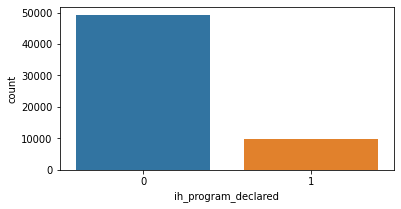

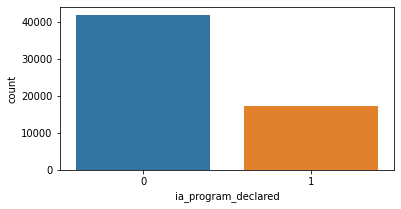

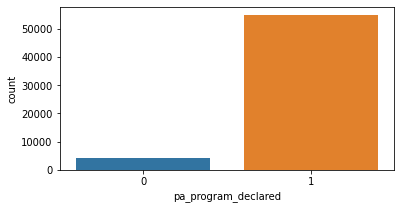

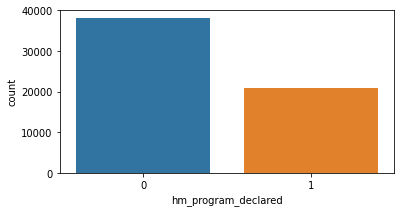

In [ ]:
for icol in cfg_col_binary:
    plt.figure(figsize=(6,3));
    chart=sns.countplot(x=icol, data=df)
    chart.set_xticklabels(chart.get_xticklabels())

2. Categorical Features

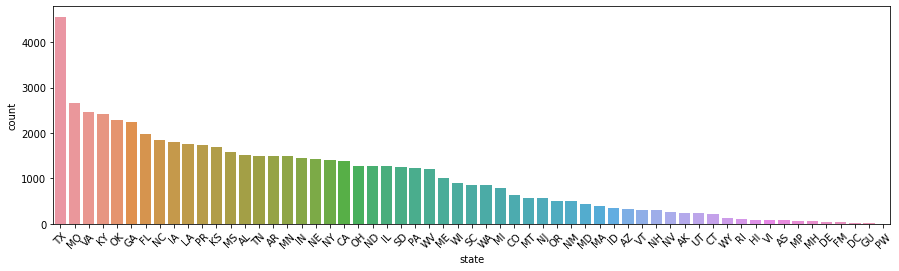

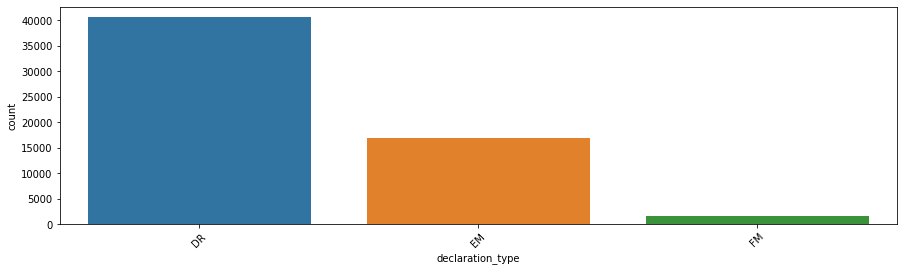

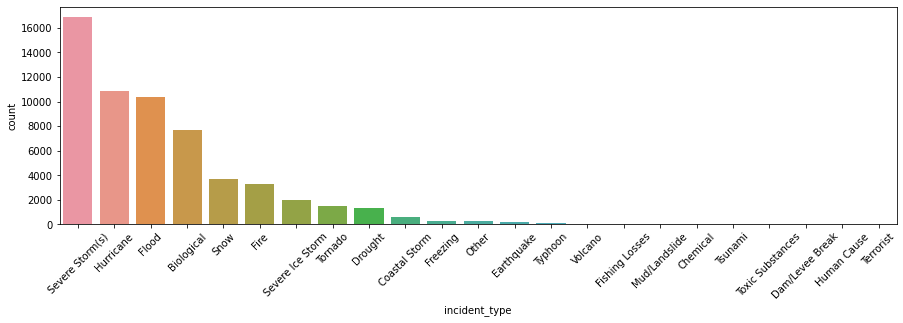

In [ ]:
for icol in cfg_col_cat:
    plt.figure(figsize=(15,4));
    chart=sns.countplot(x=icol, data=df, order = df[icol].value_counts().index)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

Dummy Variable: OHE

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
num_features = ['fy_declared','Quarter','ih_program_declared','ia_program_declared','pa_program_declared','hm_program_declared']
num_transformers= Pipeline(steps=[('imputer', SimpleImputer(strategy='constant',fill_value= 0))])
cat_features=['state','declaration_type','incident_type']
cat_transformers=Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),
                                 ('cat_encoder', OneHotEncoder(sparse=False))
                                 ] )
preprocess_pipeline = ColumnTransformer(
    transformers=[ ("numeric", num_transformers, num_features),
                   ("categorical", cat_transformers, cat_features)
                 ])
X = preprocess_pipeline.fit_transform(df)
X = pd.DataFrame(X)

In [ ]:
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,1953.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1953.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1953.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1953.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1953.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Cleaning

In [ ]:
gd=X.groupby([0,1]).sum()
gd.to_csv(r'Grouped_us_disaster.csv',index=True)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Grouped_us_disaster.csv to Grouped_us_disaster.csv


In [ ]:
import io
data = pd.read_csv(io.BytesIO(uploaded['Grouped_us_disaster.csv'])) 

In [ ]:
index=data.columns
data['Total']=data['State_AK']
for i in range(7,65):
  data['Total']=data['Total']+data[index[i]]
a=data['Total'].min()
b=data['Total'].max()
data['N_Total']=(data['Total']-a)/(b-a)

In [ ]:
data['ind']=data['Year']+data['Quarter']/4
data=data.set_index(data['ind'])
data

,Year,Quarter,ih_program_declared,ia_program_declared,pa_program_declared,hm_program_declared,State_AK,State_AL,State_AR,State_AS,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_FM,State_GA,State_GU,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MH,State_MI,State_MN,State_MO,State_MP,State_MS,State_MT,State_NC,State_ND,...,State_TN,State_TX,State_UT,State_VA,State_VI,State_VT,State_WA,State_WI,State_WV,State_WY,declaration_type_DR,declaration_type_EM,declaration_type_FM,Biological,Chemical,Coastal Storms,Dam/Levee Break,Drought,Earthquake,Fire,Fishing Losses,Flood,Freezing,Human Cause,Hurricane,Mud/Landslide,Other,Severe Ice Storm,Severe Storm(s),Snow,Terrorist,Tornado,Toxic Substances,Tsunami,Typhoon,Volcano,GDP,Total,N_Total,ind
ind,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1953.50,1953,2,0,9,9,9,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,2,0,0,0,0,1,0,0,...,0,2,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2718.709,9,0.001510,1953.50
1953.75,1953,3,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2703.411,1,0.000168,1953.75
1954.00,1953,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2662.482,0,0.000000,1954.00
1954.25,1954,1,0,2,2,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2649.755,2,0.000336,1954.25
1954.50,1954,2,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2652.643,1,0.000168,1954.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019.25,2019,1,44,0,267,267,3,1,0,0,0,2,0,0,0,0,0,0,0,0,0,80,0,0,0,14,0,0,0,0,0,0,0,1,0,0,11,0,21,0,...,0,36,0,0,0,0,8,0,0,0,266,0,1,0,0,0,0,0,3,1,0,206,0,0,21,0,0,0,35,0,0,1,0,0,0,0,18927.281,267,0.044791,2019.25
2019.50,2019,2,75,0,619,557,1,12,33,0,1,30,0,0,0,0,0,0,0,1,0,1,6,0,0,103,61,14,0,0,0,0,0,55,16,0,39,8,0,19,...,59,0,0,0,0,6,0,0,0,0,558,70,1,0,0,0,0,0,0,1,0,309,0,0,0,0,0,0,306,0,0,12,0,0,1,0,19021.860,629,0.105519,2019.50
2019.75,2019,3,29,0,626,271,2,0,4,0,1,2,0,0,0,0,73,0,12,0,0,0,0,28,0,0,0,83,0,0,0,0,0,0,88,0,0,1,101,0,...,0,5,1,0,4,0,0,21,6,0,261,361,12,0,0,42,0,0,2,12,0,110,0,0,277,0,0,0,191,0,0,0,0,0,0,0,19121.112,634,0.106358,2019.75


## EDA

In [ ]:
def my_plot(df,x,gdp,dcl,title='',xlabel='Date',ylabel='Normalized_Data',dpi=100):
    plt.figure(figsize=(12,4),dpi=dpi)
    plt.plot(x,gdp,color='tab:red')
    plt.plot(x,dcl,color='tab:blue')
    plt.gca().set(title=title,xlabel=xlabel,ylabel=ylabel)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
a=len(data.GDP)
ir=np.zeros(a)
for i in range(a-1):
  ir[i+1]=data.GDP.iloc[i+1]/data.GDP.iloc[i]-1
data['ir']=ir

In [ ]:
a=data['ir'].min()
b=data['ir'].max()
data['N_ir']=(data['ir']-a)/(b-a)

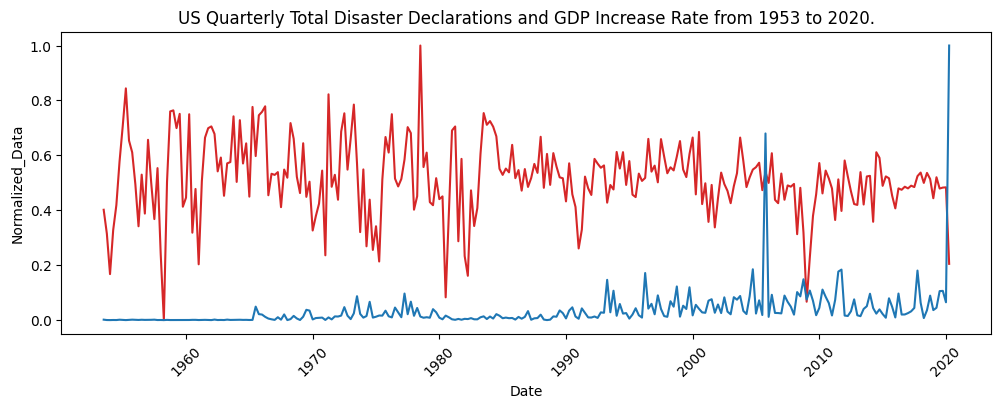

In [ ]:
my_plot(data,x=data.index,gdp=data.N_ir,dcl=data.N_Total,title='US Quarterly Total Disaster Declarations and GDP Increase Rate from 1953 to 2020.')

<Figure size 432x216 with 0 Axes>

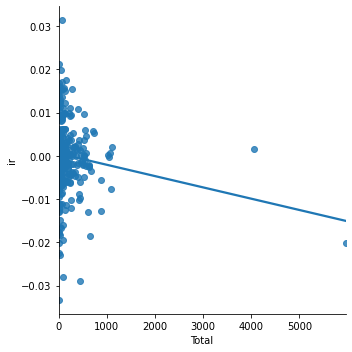

<Figure size 432x216 with 0 Axes>

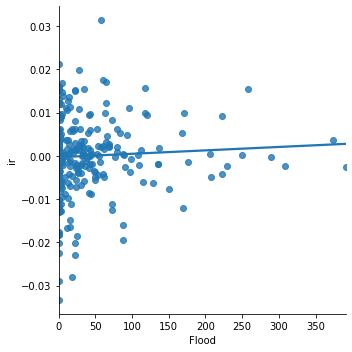

<Figure size 432x216 with 0 Axes>

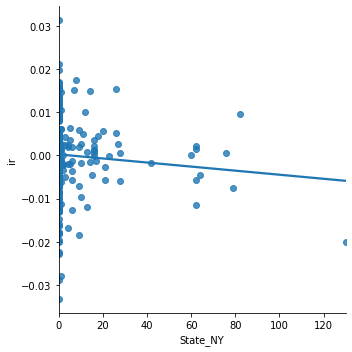

<Figure size 432x216 with 0 Axes>

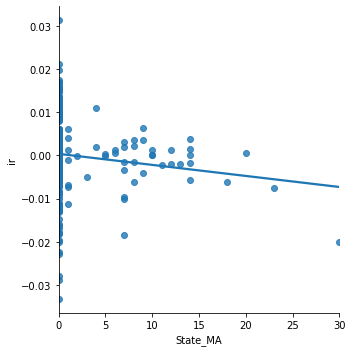

In [ ]:
cfg_col_X=['Total','Flood','State_NY','State_MA']
cfg_col_Y='ir'
for icol in cfg_col_X:
    plt.figure(figsize=(6,3));
    sns.lmplot(x=icol, y=cfg_col_Y, data=data, ci=None);

## Training

In [ ]:
from sklearn.model_selection import train_test_split
df_X=data.drop(['GDP','Year','Quarter','N_Total','ind','ir'],axis=1)
df_Y=data['ir']
df_trainX, df_trainY= df_X[:2015], df_Y[:2015]
df_testX, df_testY = df_X[2015:], df_Y[2015:]

(1) OLS

In [ ]:
from sklearn.linear_model import LinearRegression

mod_skols = LinearRegression()
scores = cross_validate(mod_skols, df_trainX, df_trainY, cv=5,
                         scoring=('r2', 'neg_mean_squared_error'),
                         return_train_score=True)
print("%.4f" %scores['train_r2'].mean())

0.3795


In [ ]:
mod_skols.fit(df_trainX, df_trainY)
y_pred=mod_skols.predict(df_testX)
df_testY=np.array(df_testY)

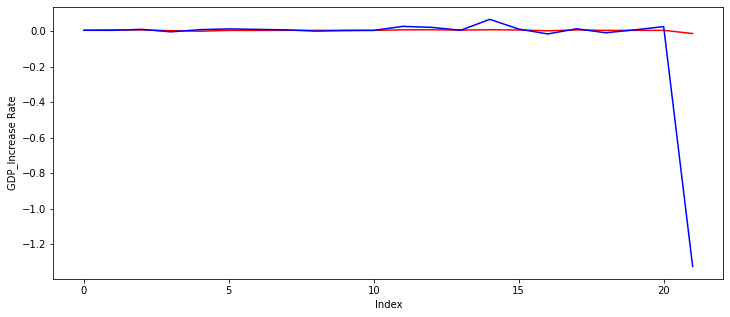

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(df_testY,c='red',label='Actual')
plt.plot(y_pred,c='blue',label='Pred')
plt.xlabel("Index")
plt.ylabel("GDP_Increase Rate")
plt.show()

(2) XGBoost

In [ ]:
from xgboost import XGBRegressor
mod_xgb = XGBRegressor(max_depth=50, learning_rate=0.1, n_estimators=150)
scores = cross_validate(mod_xgb, df_trainX, df_trainY, cv=5,
                         scoring=('r2', 'neg_mean_squared_error'),
                         return_train_score=True)
print("%.4f" %scores['train_r2'].mean())
mod_xgb.fit(df_trainX, df_trainY)
y_pred=mod_xgb.predict(df_testX)

[19:25:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8647
[19:25:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


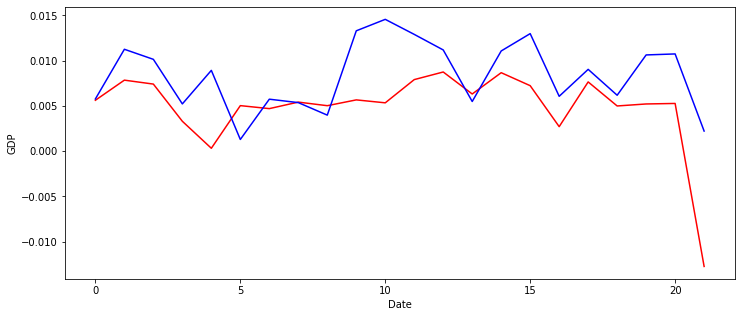

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(df_testY,c='red',label='Actual')
plt.plot(y_pred,c='blue',label='Pred')
plt.xlabel("Date")
plt.ylabel("GDP")
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
df_trainX = sc.fit_transform(df_trainX)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

trainX = np.reshape(df_trainX, (len(df_trainX), 90,1))
model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(df_trainX.shape[1],1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, df_trainY, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
5/5 - 0s - loss: 0.0767
Epoch 2/100
5/5 - 0s - loss: 0.0732
Epoch 3/100
5/5 - 0s - loss: 0.0602
Epoch 4/100
5/5 - 0s - loss: 0.0497
Epoch 5/100
5/5 - 0s - loss: 0.0515
Epoch 6/100
5/5 - 0s - loss: 0.0457
Epoch 7/100
5/5 - 0s - loss: 0.0398
Epoch 8/100
5/5 - 0s - loss: 0.0367
Epoch 9/100
5/5 - 0s - loss: 0.0368
Epoch 10/100
5/5 - 0s - loss: 0.0411
Epoch 11/100
5/5 - 0s - loss: 0.0325
Epoch 12/100
5/5 - 0s - loss: 0.0307
Epoch 13/100
5/5 - 0s - loss: 0.0304
Epoch 14/100
5/5 - 0s - loss: 0.0265
Epoch 15/100
5/5 - 0s - loss: 0.0233
Epoch 16/100
5/5 - 0s - loss: 0.0269
Epoch 17/100
5/5 - 0s - loss: 0.0261
Epoch 18/100
5/5 - 0s - loss: 0.0255
Epoch 19/100
5/5 - 0s - loss: 0.0220
Epoch 20/100
5/5 - 0s - loss: 0.0201
Epoch 21/100
5/5 - 0s - loss: 0.0216
Epoch 22/100
5/5 - 0s - loss: 0.0218
Epoch 23/100
5/5 - 0s - loss: 0.0189
Epoch 24/100
5/5 - 0s - loss: 0.0176
Epoch 25/100
5/5 - 0s - loss: 0.0189
Epoch 26/100
5/5 - 0s - loss: 0.0199
Epoch 27/100
5/5 - 0s - loss: 0.0159
Epoch 28/1

In [ ]:
df_testX = sc.fit_transform(df_testX)
testX = np.reshape(df_testX, (len(df_testX), 90, 1))
predicted_rGDP = model.predict(testX)

In [ ]:
data_test=pd.DataFrame(df_testY)

In [ ]:
data_test['rGDP_Prediction_lstm'] = predicted_rGDP

In [ ]:
y_real=np.array(df_testY.reshape(1,22))

In [ ]:
y_pred=np.array(predicted_rGDP.reshape(1,22))

In [ ]:
correlation_matrix = np.corrcoef(y_real, y_pred)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

0.7299664492702913


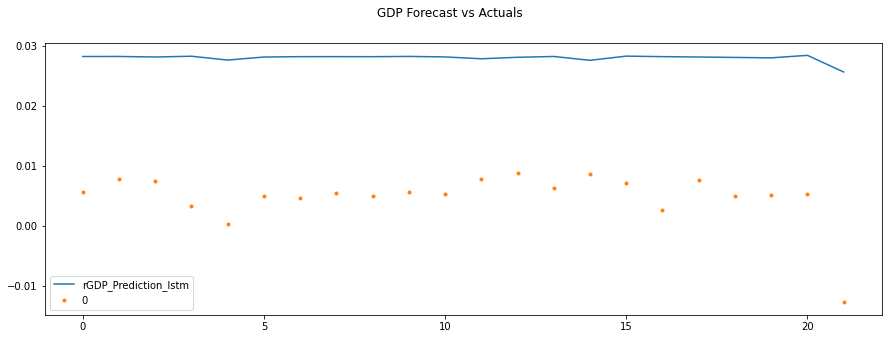

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_test[['rGDP_Prediction_lstm',0]].plot(ax=ax,
                                              style=['-','.'])
##ax.set_xbound(lower='2018-02-28', upper='2020-06-30')
##ax.set_ylim(100, 108)
plot = plt.suptitle('GDP Forecast vs Actuals')

In [ ]:
import shap
explainer = shap.TreeExplainer(mod_xgb, df_trainX)
shap_values = explainer.shap_values(df_trainX)

shap.summary_plot(shap_values, df_trainX)

ModuleNotFoundError: ignored